In [12]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
import os
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

path_sav_fig = f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/figure/"
if not os.path.isdir(path_sav_fig):
    os.mkdir(path_sav_fig)

key_Energy = "Erec"
key_tag = "evtType"
dir_map_tags = {0:"pES", 1:"eES"}

# Load Prediction Outputs
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz",
             allow_pickle=True) as f:
    dir_events = f["dir_events"].item()

# Erec_max = max( dir_events[key_Energy] )
Erec_max = 12.5
dir_diff_option_for_events = {"Without IBDp":dir_events}
print(dir_events[key_Energy])

[0.45743498 0.40903294 1.0430361  ... 0.18072918 0.37840062 0.38591179]


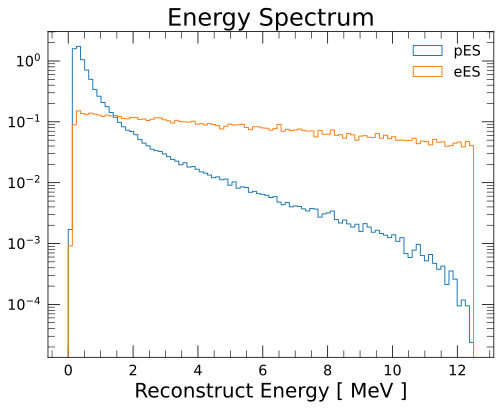

In [20]:
bins_equen= np.linspace(0, Erec_max ,100)
for tag in dir_map_tags.keys():
    plt.hist(dir_events[key_Energy][dir_events[key_tag]==tag],bins=bins_equen, histtype="step", label=dir_map_tags[tag],
             density=True)
plt.xlabel("Reconstruct Energy [ MeV ]")
plt.title("Energy Spectrum")
plt.semilogy()
plt.legend()
plt.savefig(path_sav_fig+"ebnergy_spectrum.png")


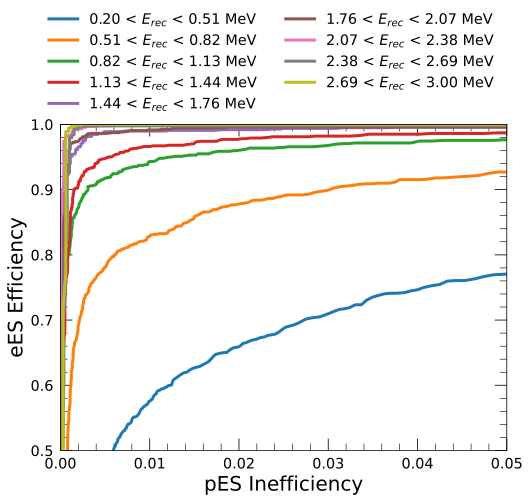

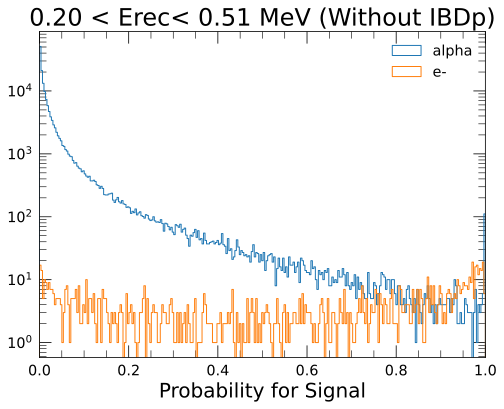

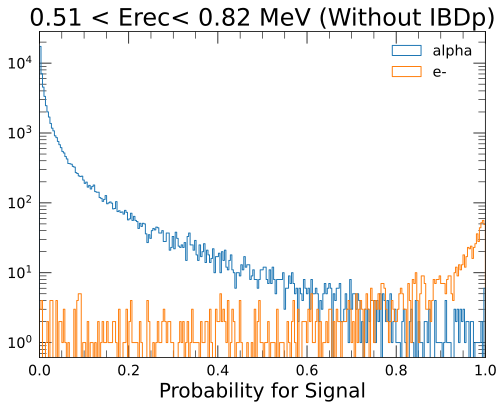

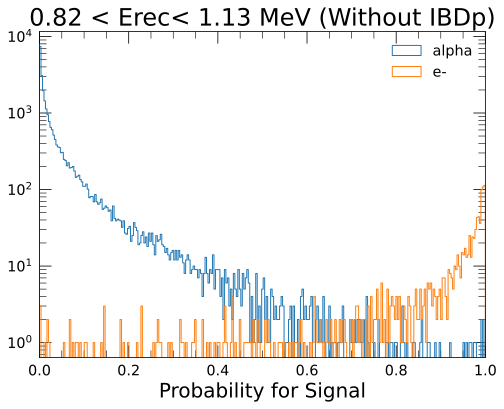

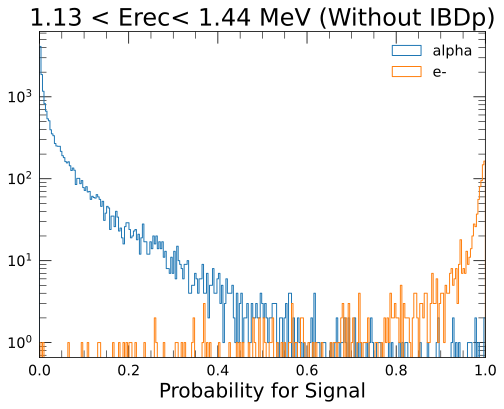

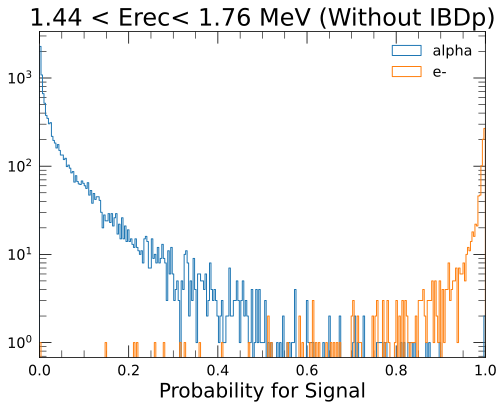

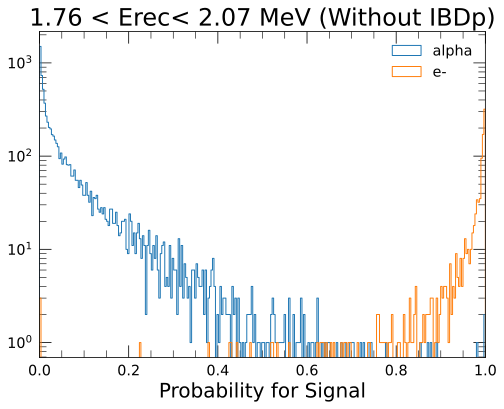

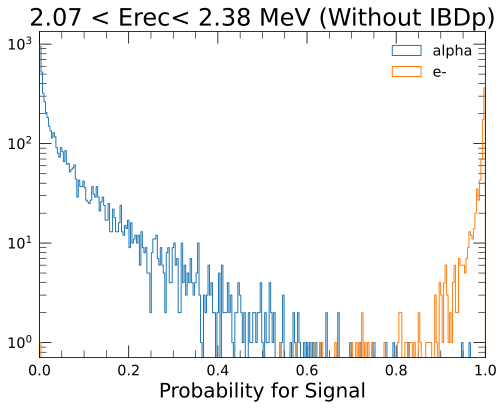

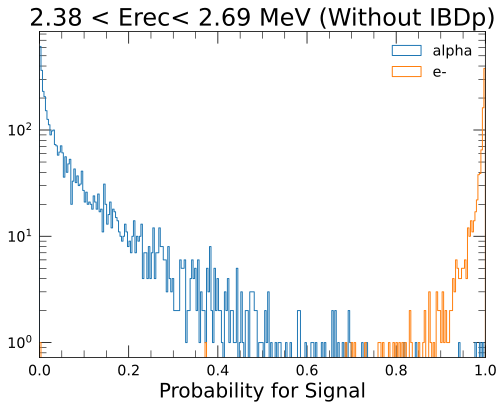

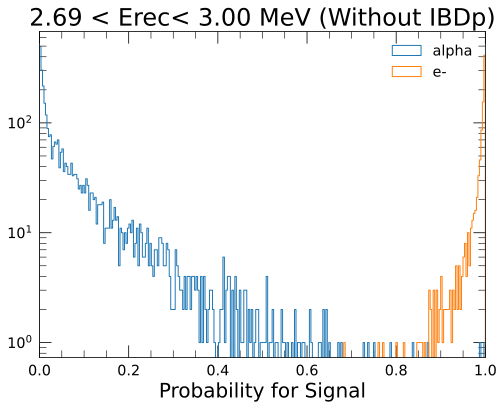

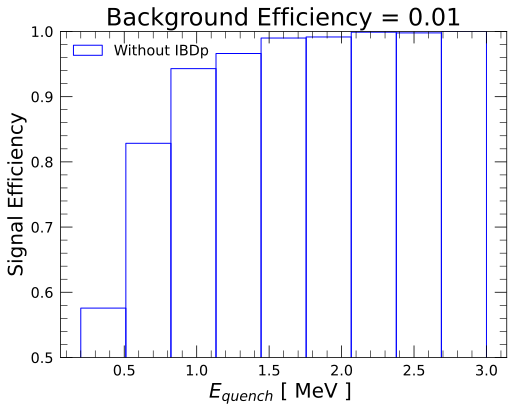

In [17]:
def GetBinCenter(edge):
    return (edge[:-1]+edge[1:])/2

def GetSigEff( v_eff_sig, v_eff_bkg, certain_eff_bkg=0.01):
    from scipy.interpolate import interp1d
    v_eff_bkg = np.array(v_eff_bkg)
    v_eff_sig = np.array(v_eff_sig)
    f = interp1d(v_eff_bkg[1:], v_eff_sig[1:], kind="linear")
    eff_sig_return = f(certain_eff_bkg)
    return (certain_eff_bkg, eff_sig_return)

def PlotPredictDistribution(dir_events_in_quench_bins:dict, title="", bins=np.linspace(0,1,300)):
    n0, bins0, patches0 = plt.hist(dir_events_in_quench_bins["PSD"][dir_events_in_quench_bins[key_tag]==0], histtype="step",
             bins=bins, label="alpha")
    n1, bins1, patches1 = plt.hist(dir_events_in_quench_bins["PSD"][dir_events_in_quench_bins[key_tag]==1], histtype="step",
             bins=bins, label="e-")
    plt.semilogy()
    plt.xlabel("Probability for Signal")
    plt.legend()
    plt.xlim(0,1)
    plt.title(title)
    return (n0,n1)

def GetSignalEfficiency(n0, n1,dir_events:dict,certain_eff_bkg:float,
                        label:str="", axes:plt.Axes=None,
                        ls=None,color=None, extra_label=""):
    # n0 = dir_events["PSD"][dir_events[key_tag]==0]
    # n1 = dir_events["PSD"][dir_events[key_tag]==1]
    eff_bkg = []
    eff_sig = []
    for i in range(len(n0)):
        eff_bkg.append(np.sum(n0[i:]) * 1.0 / np.sum(n0))
        eff_sig.append(np.sum(n1[i:]) * 1.0 / np.sum(n1))
    line = axes.plot(eff_bkg,eff_sig, label=label,
              ls=ls, color=color)
    if not extra_label=="":
        axes.plot(eff_bkg,eff_sig, label=extra_label,
                         ls=ls, color=line[0].get_color())

    (certain_eff_bkg, eff_sig_return) = GetSigEff(v_eff_bkg=eff_bkg, v_eff_sig=eff_sig,
                                                  certain_eff_bkg=certain_eff_bkg)
    return (eff_sig_return, line)

from PlotTools import GetListOfLineColor
import matplotlib.colors as colors
v_colors = list(colors._colors_full_map.values())
# Get signal efficiency about energy
certain_eff_bkg = 0.01
equen_bins = np.linspace(0.2, 3, 10)
# equen_bins = np.linspace(0.2, Erec_max, 20)
fig,ax = plt.subplots(1,1)
dir_v_eff_sig = {}
v_lines = [] # save the line so we can get the color to draw another option_calib
for i_option, calib_option in enumerate(dir_diff_option_for_events.keys()):
    v_eff_sig = []
    for i_equen_bin in range(len(equen_bins)-1):
        if i_option>0:
            # if i_equen_bin==0:
            #     label = "coti-waverec"
            # else:
            label = None
            color = v_lines[i_equen_bin][0].get_color()
        else:
            label = f"{equen_bins[i_equen_bin]:.2f} < "+ "$E_{rec}$"+ f" < {equen_bins[i_equen_bin+1]:.2f} MeV"
            color = None
        plt.figure()
        dir_events_in_quench_bins = {}
        index_equen = (dir_diff_option_for_events[calib_option][key_Energy]<equen_bins[i_equen_bin+1]) & (dir_diff_option_for_events[calib_option][key_Energy]>equen_bins[i_equen_bin])
        for key in dir_diff_option_for_events[calib_option].keys():
            dir_events_in_quench_bins[key] = dir_diff_option_for_events[calib_option][key][index_equen]
        (n0, n1)=PlotPredictDistribution(dir_events_in_quench_bins,
                                title=f"{equen_bins[i_equen_bin]:.2f} < Erec< {equen_bins[i_equen_bin+1]:.2f} MeV ({calib_option})")
        eff_sig, line = GetSignalEfficiency(n0, n1,dir_events_in_quench_bins, certain_eff_bkg=certain_eff_bkg,
                                  label=label,
                                  axes=ax,color=color,
                                   ls="--" if calib_option=="coti" else "-",
                                            extra_label="")
        v_eff_sig.append(eff_sig)
        if i_option ==0:
            v_lines.append(line)
    dir_v_eff_sig[calib_option] = v_eff_sig

# ax.plot([0,1],[0,0], color=v_lines[0][0].get_color(), label="decon-waverec")
ax.set_xlim(0,0.05)
ax.set_ylim(0.5,1)
ax.set_xlabel(f"{dir_map_tags[0]} Inefficiency")
ax.set_ylabel(f"{dir_map_tags[1]} Efficiency")
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=2,loc="lower right")
# ax.legend()
ax.figure.savefig(path_sav_fig+"roc_curve_diff_quench.png",bbox_inches='tight')

plt.figure()
v_colors = GetListOfLineColor()
for i,calib_option in enumerate(dir_diff_option_for_events.keys()):
    plt.bar(GetBinCenter(equen_bins), dir_v_eff_sig[calib_option], width=np.diff(equen_bins), fill=False,
            edgecolor=v_colors[i], label=calib_option)
plt.legend()
plt.xlabel("$E_{quench}$ [ MeV ] ")
plt.ylabel("Signal Efficiency")
plt.title(f"Background Efficiency = {certain_eff_bkg}")
plt.ylim(0.5,1)
plt.savefig(path_sav_fig+"Signal_eff_diff_equen.png")

In [15]:
%precision 8
import pandas as pd
# from pd.table.plotting import table
# ax = plt.subplot(111,frameon=False)
v_label = []
v_keys = list(dir_v_eff_sig.keys())
for key in v_keys:
    if dir_v_eff_sig[key][-1]!=np.mean(dir_v_eff_sig[key]):
        dir_v_eff_sig[key].append(np.mean(dir_v_eff_sig[key]))
for i in range(len(equen_bins)-1):
    v_label.append(f"{equen_bins[i]:.2f} - {equen_bins[i+1]:.2f} MeV")
v_label.append("Mean")
# pd.set_option('precision', 3)
if compare_with_coti:
    eff_sig_decon = np.array(dir_v_eff_sig[v_keys[0]],dtype="float64")*100
    eff_sig_coti = np.array(dir_v_eff_sig[v_keys[1]],dtype="float64")*100
    df = pd.DataFrame([eff_sig_decon,eff_sig_coti, 100*np.abs(eff_sig_coti-eff_sig_decon)/eff_sig_decon],
            columns=v_label, index=list(dir_v_eff_sig.keys())+["Relative Difference (%)"] )
else:
    eff_sig_decon = np.array(dir_v_eff_sig[v_keys[0]],dtype="float64")*100
    print(eff_sig_decon, v_label)
    df = pd.DataFrame([eff_sig_decon],
                      columns=v_label, index=list(dir_v_eff_sig.keys()))

df.T.columns.name = f'Bkg Inefficiency = {certain_eff_bkg*100}%'
df.T

NameError: name 'compare_with_coti' is not defined